### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, GRU, LSTM
from keras_preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

### Reading data from Druglib

In [2]:
train_ds = pd.read_csv('./data/lab3/drugLibTrain_raw.tsv', sep='\t').dropna()
test_ds = pd.read_csv('./data/lab3/drugLibTest_raw.tsv', sep='\t').dropna()

### Data preparation

In [3]:
train_ds[['benefitsReview', 'sideEffectsReview', 'commentsReview']] = train_ds[['benefitsReview', 'sideEffectsReview', 'commentsReview']].astype('string') 
test_ds[['benefitsReview', 'sideEffectsReview', 'commentsReview']] = test_ds[['benefitsReview', 'sideEffectsReview', 'commentsReview']].astype('string') 

In [4]:
# Define the mapping functions
def map_rating(x):
    if x < 4:
        return 0
    elif 4 <= x < 7:
        return 1
    else:
        return 2

def map_effectiveness(x):
    if x == "Ineffective":
        return 0
    elif x in ["Marginally Effective", "Moderately Effective"]:
        return 1
    else:
        return 2

def map_side_effects(x):
    if x == "No Side Effects":
        return 0
    elif x in ["Mild Side Effects", "Moderate Side Effects"]:
        return 1
    else:
        return 2

# Apply mapping functions to train_ds
train_ds['rating'] = train_ds['rating'].apply(map_rating)
train_ds['effectiveness'] = train_ds['effectiveness'].apply(map_effectiveness)
train_ds['sideEffects'] = train_ds['sideEffects'].apply(map_side_effects)

# Apply mapping functions to test_ds
test_ds['rating'] = test_ds['rating'].apply(map_rating)
test_ds['effectiveness'] = test_ds['effectiveness'].apply(map_effectiveness)
test_ds['sideEffects'] = test_ds['sideEffects'].apply(map_side_effects)

# Convert object columns to category type
object_cols = train_ds.select_dtypes(include='object').columns
train_ds[object_cols] = train_ds[object_cols].astype('category')
test_ds[object_cols] = test_ds[object_cols].astype('category')

# Encode categorical columns using LabelEncoder
encoder = LabelEncoder()

for col in object_cols:
    combined_values = pd.concat([train_ds[col], test_ds[col]])
    encoder.fit(combined_values)
    train_ds[col] = encoder.transform(train_ds[col])
    test_ds[col] = encoder.transform(test_ds[col])


In [5]:
int_cols_train = train_ds.select_dtypes(include='integer').columns
train_ds[int_cols_train] = np.asarray(train_ds[int_cols_train]).astype(np.int32)
int_cols_test = train_ds.select_dtypes(include='integer').columns
train_ds[int_cols_test] = np.asarray(train_ds[int_cols_test]).astype(np.int32)

In [6]:
def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

In [7]:
# Define text columns
text_columns = ['benefitsReview', 'sideEffectsReview', 'commentsReview']

# Convert text to lowercase
train_ds[text_columns] = train_ds[text_columns].apply(lambda x: x.str.lower())
test_ds[text_columns] = test_ds[text_columns].apply(lambda x: x.str.lower())

# Flatten text data
text_data = train_ds[text_columns].values.flatten()
text_data = [str(element) for element in text_data]

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(text_data)

# Tokenize and pad sequences for each text column
for col in text_columns:
    # Tokenize training data
    sequences_train = tokenizer.texts_to_sequences(train_ds[col])
    padded_sequences_train = pad_sequences(sequences_train, padding='post')
    train_ds[col] = padded_sequences_train
    
    # Tokenize test data
    sequences_test = tokenizer.texts_to_sequences(test_ds[col])
    padded_sequences_test = pad_sequences(sequences_test, padding='post')
    test_ds[col] = padded_sequences_test

# Convert back to numpy arrays
train_ds[text_columns] = train_ds[text_columns].apply(lambda x: np.array(x.tolist()))
test_ds[text_columns] = test_ds[text_columns].apply(lambda x: np.array(x.tolist()))


In [8]:
def split_data_by_target_column(cols,X_train,X_test):
    X_train = train_ds.drop(cols,axis=1)
    X_test = test_ds.drop(cols,axis=1)
    
    Y_train = train_ds[cols]
    Y_test = test_ds[cols]
    return X_train, X_test, Y_train, Y_test

### Plotting functions

In [9]:
def plot_roc_auc(y_pred_probs, y_true):
    n_classes = 3
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    colors = ['magenta', 'cyan', 'lime']
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], label='Class {0} (AUC = {1:.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    
    plt.show()

In [10]:
def plot_evaluation_metrics(y_test, y_pred, y_pred1, model, X_test):
    print("F1 score:", f1_score(y_test, y_pred1, average='macro'))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred1))
    print("Precision Score:", precision_score(y_test, y_pred1, average='macro'))
    print("Recall Score:", recall_score(y_test, y_pred1, average='macro'))
    print("Classification Accuracy Score:", accuracy_score(y_test, y_pred1))
    
    cm = confusion_matrix(y_test, y_pred1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='GnBu')
    plt.show()
    
    plot_roc_auc(y_pred, y_test)


In [11]:
def plot_history(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    # Plot Training and Validation Loss
    ax[0].plot(history.history['loss'], label='Training Loss', color='red')
    ax[0].plot(history.history['val_loss'], label='Validation Loss', color='green')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot Training and Validation Accuracy
    ax[1].plot(history.history['accuracy'], label='Training Accuracy', color='red')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    
    plt.show()


### Models

#### RNN

In [12]:
def create_rnn(target, X_train):
    num_classes = np.sort(np.array(train_ds[target].unique()))
    rnn_model = Sequential(name='RNN')
    rnn_model.add(SimpleRNN(units=64, activation='relu'))
    rnn_model.add(Dense(units=len(num_classes), activation='sigmoid'))
    rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return rnn_model

#### GRU

In [13]:
def create_gru(target, X_train):
    num_classes = np.sort(np.array(train_ds[target].unique()))
    gru_model = Sequential(name='GRU')
    gru_model.add(GRU(units=64, activation='relu'))
    gru_model.add(Dense(units=len(num_classes), activation='sigmoid'))
    gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return gru_model

#### LSTM

In [14]:
def create_lstm(target, X_train):
    num_classes = np.sort(np.array(train_ds[target].unique()))
    lstm_model = Sequential(name='LSTM')
    lstm_model.add(LSTM(units=64, activation='relu'))
    lstm_model.add(Dense(units=len(num_classes), activation='sigmoid'))
    lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return lstm_model

### Testing models

In [15]:
targetColumns = ["rating","effectiveness","sideEffects"]

rating
RNN
Train
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4121 - loss: 77.7132 - val_accuracy: 0.4777 - val_loss: 12.0501
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5356 - loss: 7.6523 - val_accuracy: 0.4945 - val_loss: 5.2759
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5348 - loss: 4.2835 - val_accuracy: 0.5104 - val_loss: 3.7376
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5471 - loss: 2.8583 - val_accuracy: 0.5303 - val_loss: 2.9506
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5629 - loss: 2.8489 - val_accuracy: 0.5482 - val_loss: 3.3096
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5829 - loss: 3.1440 - val_accuracy: 0.5780 - val_loss: 2.7307
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5559 - loss: 2.6278 - val_accuracy: 0.5650 - val_loss: 2.4840
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6010 - loss: 2.2219 - val_a

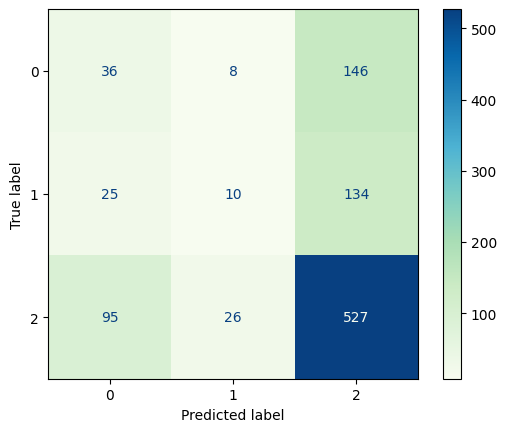

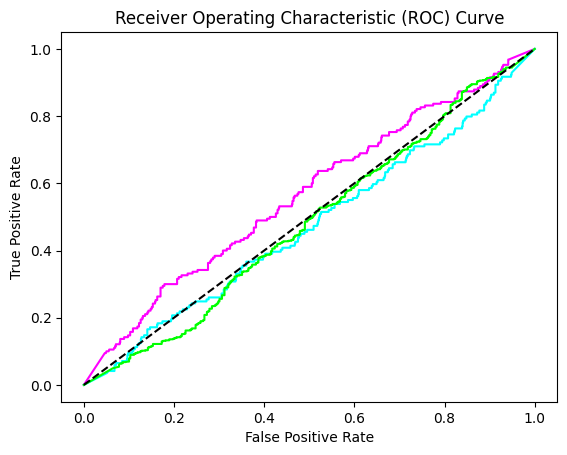

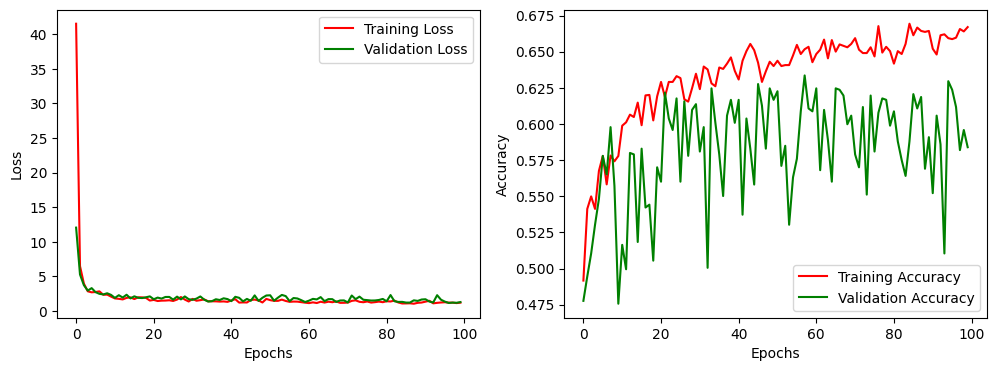

GRU
Train
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5445 - loss: 18.3484 - val_accuracy: 0.4886 - val_loss: 7.3862
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5377 - loss: 6.6205 - val_accuracy: 0.5501 - val_loss: 6.4743
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5431 - loss: 5.2955 - val_accuracy: 0.4757 - val_loss: 5.7201
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5447 - loss: 4.5150 - val_accuracy: 0.5134 - val_loss: 4.0310
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5389 - loss: 3.4154 - val_accuracy: 0.5035 - val_loss: 3.2668
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5514 - loss: 2.9394 - val_accuracy: 0.4737 - val_loss: 2.7031
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5494 - loss: 2.4650 - val_accuracy: 0.5343 - val_loss: 2.5919
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5389 - loss: 2.0891 - val_accuracy

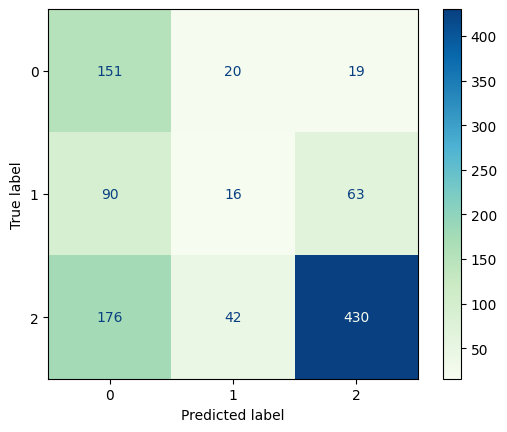

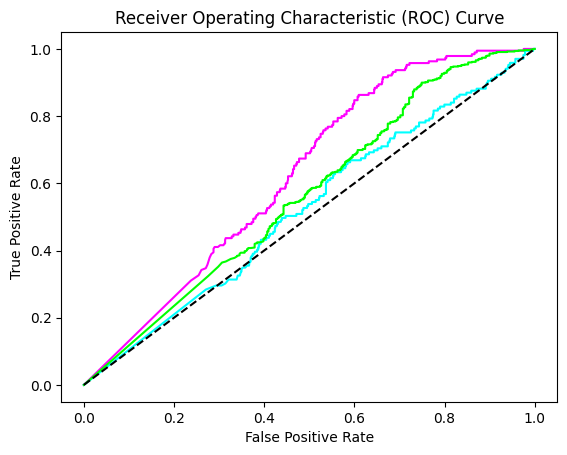

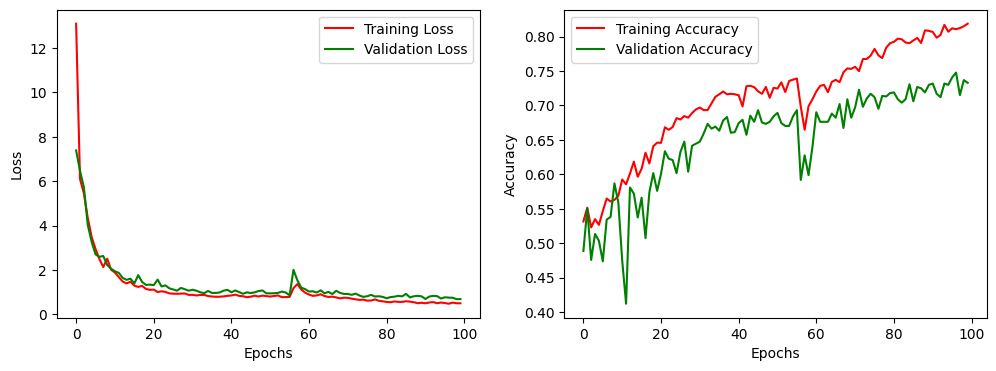

LSTM
Train
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4277 - loss: 35.1886 - val_accuracy: 0.4866 - val_loss: 19.8761
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5020 - loss: 16.2988 - val_accuracy: 0.5392 - val_loss: 11.6288
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5456 - loss: 9.8682 - val_accuracy: 0.5382 - val_loss: 8.2275
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5533 - loss: 7.0313 - val_accuracy: 0.5184 - val_loss: 6.3845
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5474 - loss: 5.0890 - val_accuracy: 0.5303 - val_loss: 3.7502
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5702 - loss: 3.0343 - val_accuracy: 0.5819 - val_loss: 2.9854
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5753 - loss: 2.3485 - val_accuracy: 0.5720 - val_loss: 2.7469
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6131 - loss: 2.4405 - val_accu

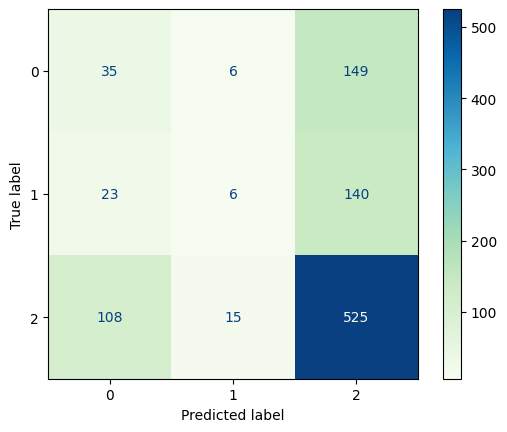

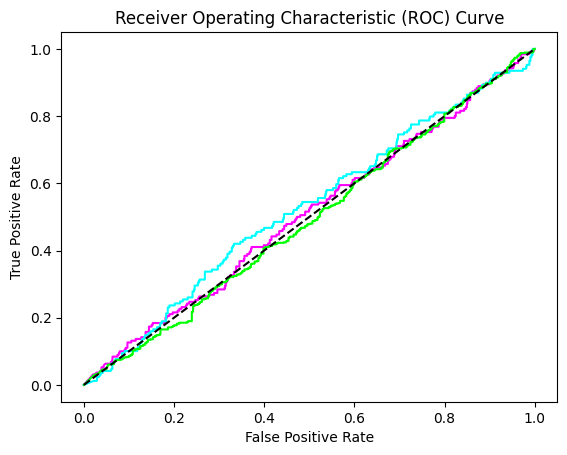

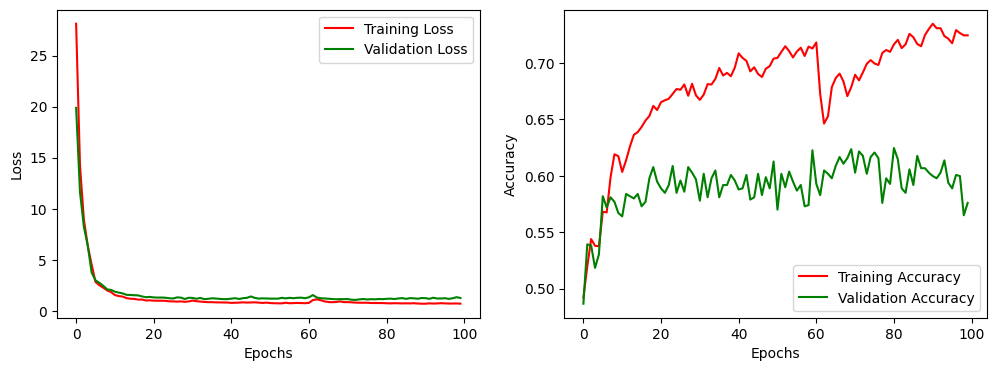

effectiveness
RNN
Train
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5130 - loss: 55.9353 - val_accuracy: 0.5154 - val_loss: 7.6478
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5660 - loss: 6.7387 - val_accuracy: 0.6286 - val_loss: 4.7140
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5996 - loss: 3.8772 - val_accuracy: 0.6246 - val_loss: 3.2734
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6322 - loss: 2.6974 - val_accuracy: 0.4359 - val_loss: 3.2294
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5651 - loss: 2.9719 - val_accuracy: 0.4657 - val_loss: 2.9366
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5971 - loss: 2.4300 - val_accuracy: 0.5789 - val_loss: 2.8515
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5944 - loss: 2.5189 - val_accuracy: 0.6892 - val_loss: 3.9504
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6321 - loss: 2.3086 -

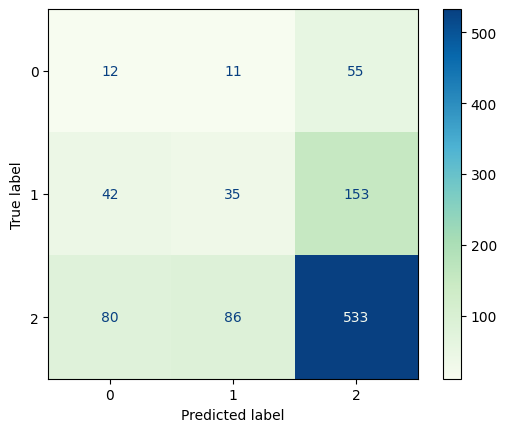

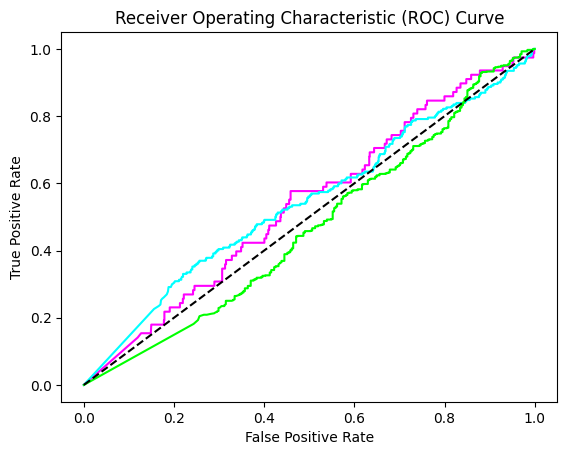

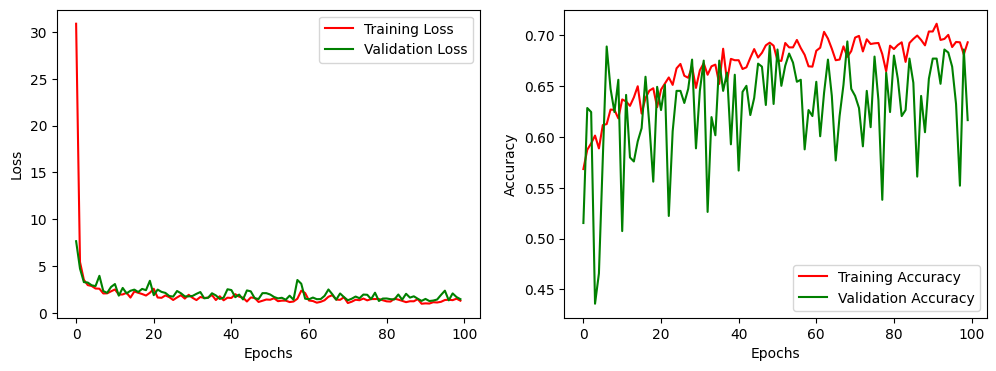

GRU
Train
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5566 - loss: 18.9379 - val_accuracy: 0.5402 - val_loss: 9.2153
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5875 - loss: 7.9584 - val_accuracy: 0.5859 - val_loss: 7.3698
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6290 - loss: 5.6105 - val_accuracy: 0.6514 - val_loss: 4.7872
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5975 - loss: 4.6776 - val_accuracy: 0.6415 - val_loss: 4.4671
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6188 - loss: 3.5664 - val_accuracy: 0.5353 - val_loss: 4.4110
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6236 - loss: 3.1389 - val_accuracy: 0.5452 - val_loss: 3.4952
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6179 - loss: 2.4911 - val_accuracy: 0.6236 - val_loss: 3.1604
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6296 - loss: 2.4810 - val_accuracy

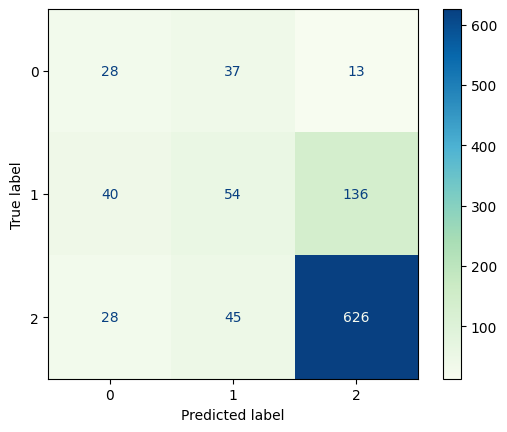

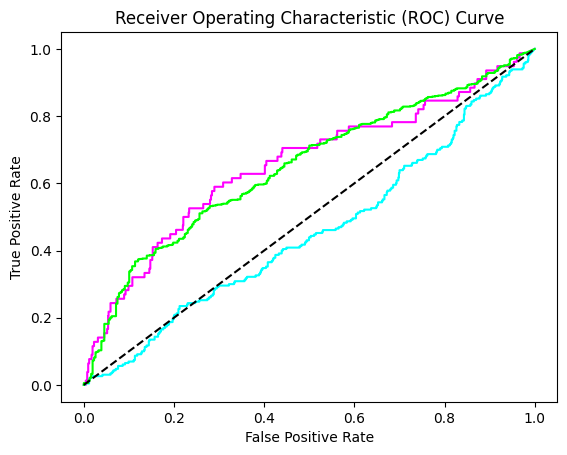

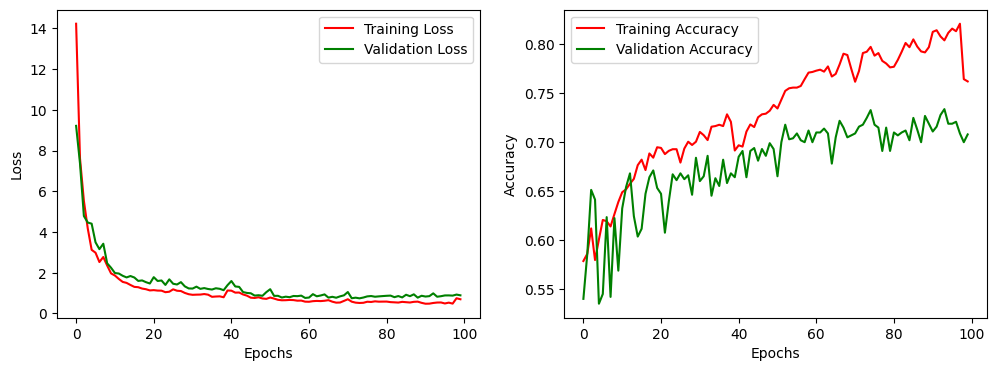

LSTM
Train
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4542 - loss: 28.8567 - val_accuracy: 0.5789 - val_loss: 10.2816
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6385 - loss: 7.2640 - val_accuracy: 0.5929 - val_loss: 5.3143
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6485 - loss: 4.8510 - val_accuracy: 0.6197 - val_loss: 3.2854
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6530 - loss: 2.7328 - val_accuracy: 0.6276 - val_loss: 2.1409
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6859 - loss: 2.0825 - val_accuracy: 0.6375 - val_loss: 1.8554
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6624 - loss: 1.5409 - val_accuracy: 0.6574 - val_loss: 1.6106
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6666 - loss: 1.3752 - val_accuracy: 0.6147 - val_loss: 1.5828
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6647 - loss: 1.2145 - val_accura

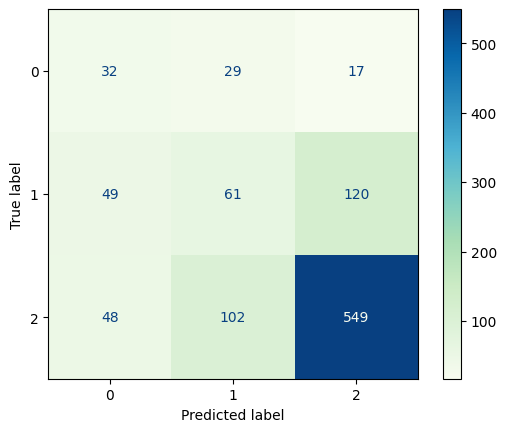

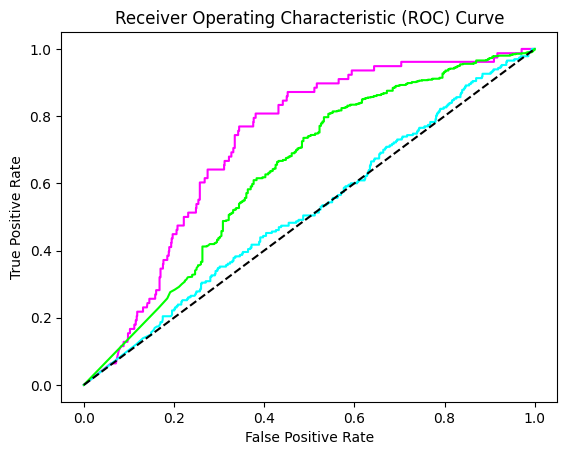

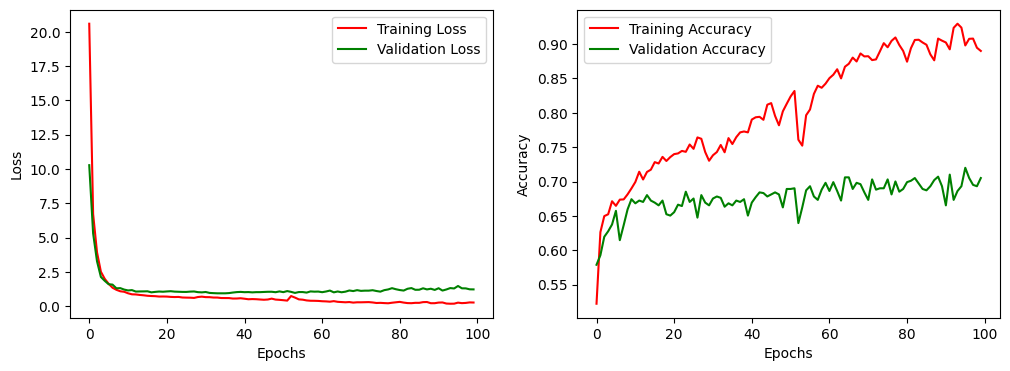

sideEffects
RNN
Train
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4167 - loss: 68.8676 - val_accuracy: 0.3863 - val_loss: 12.6254
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4155 - loss: 10.0221 - val_accuracy: 0.3813 - val_loss: 8.0236
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4324 - loss: 6.6827 - val_accuracy: 0.3803 - val_loss: 5.6990
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4507 - loss: 4.3795 - val_accuracy: 0.5015 - val_loss: 5.4589
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4575 - loss: 4.3531 - val_accuracy: 0.4896 - val_loss: 6.5656
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4573 - loss: 5.5967 - val_accuracy: 0.4528 - val_loss: 5.8338
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4577 - loss: 5.2861 - val_accuracy: 0.3108 - val_loss: 8.1357
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4457 - loss: 4.5119 -

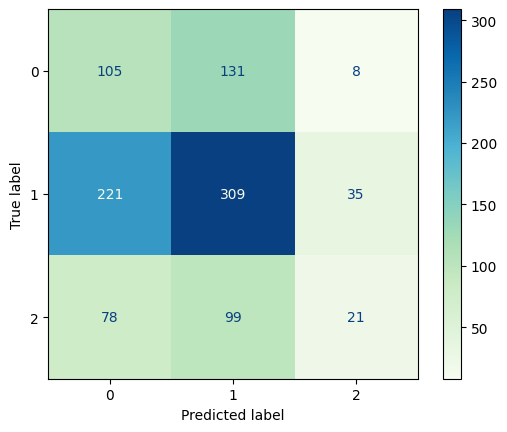

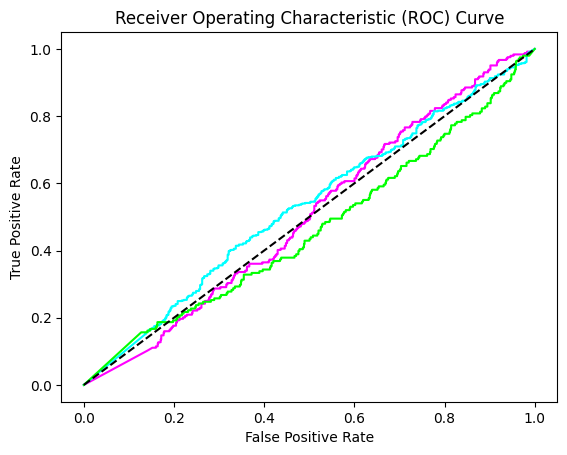

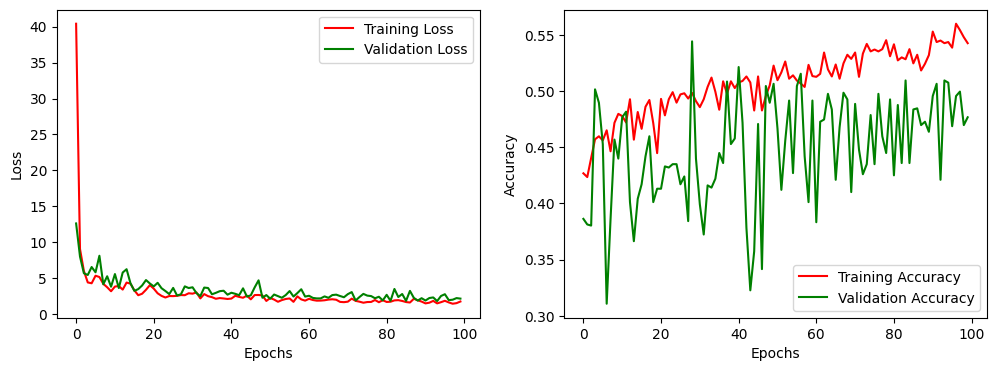

GRU
Train
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3516 - loss: 24.2064 - val_accuracy: 0.3813 - val_loss: 13.5898
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4310 - loss: 11.6975 - val_accuracy: 0.3923 - val_loss: 9.5676
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4184 - loss: 8.9518 - val_accuracy: 0.4300 - val_loss: 6.9998
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4480 - loss: 6.1814 - val_accuracy: 0.4359 - val_loss: 4.6941
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4376 - loss: 4.8146 - val_accuracy: 0.4975 - val_loss: 4.3042
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4668 - loss: 4.0563 - val_accuracy: 0.4320 - val_loss: 3.8009
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4618 - loss: 2.8808 - val_accuracy: 0.4508 - val_loss: 2.2687
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4689 - loss: 1.9636 - val_accura

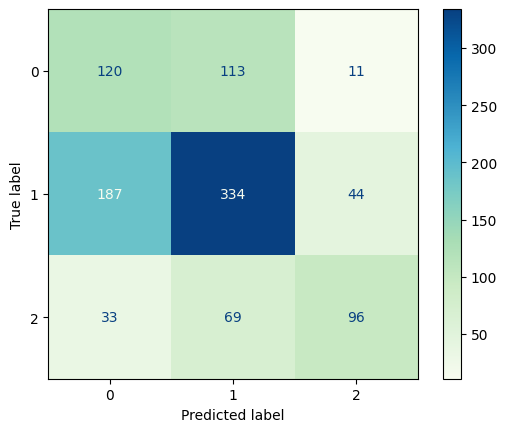

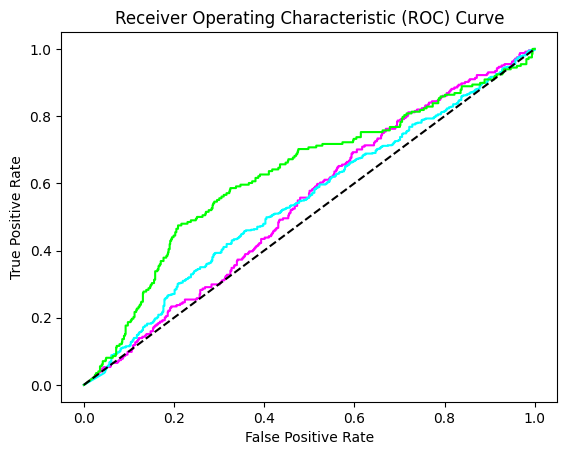

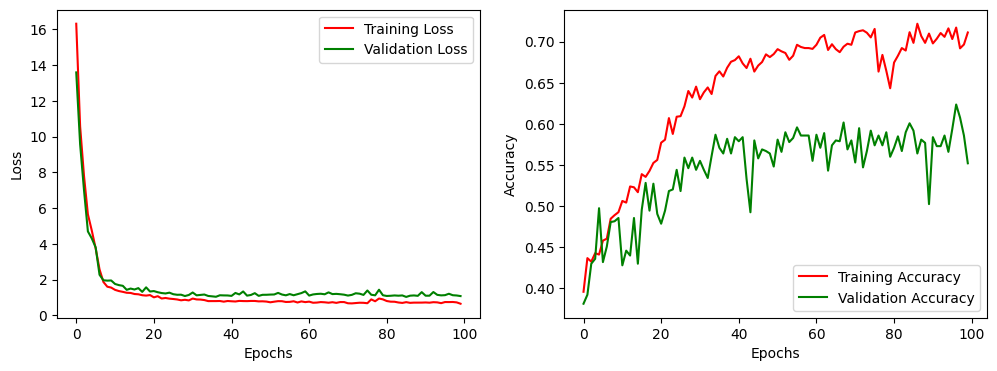

LSTM
Train
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3237 - loss: 42.7538 - val_accuracy: 0.3952 - val_loss: 16.1906
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4133 - loss: 13.2503 - val_accuracy: 0.4638 - val_loss: 7.2085
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4643 - loss: 5.9012 - val_accuracy: 0.4558 - val_loss: 4.8513
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4890 - loss: 3.6502 - val_accuracy: 0.4409 - val_loss: 4.4156
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4891 - loss: 3.2699 - val_accuracy: 0.4369 - val_loss: 3.5337
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4934 - loss: 2.4716 - val_accuracy: 0.4310 - val_loss: 2.8746
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4686 - loss: 2.0263 - val_accuracy: 0.4806 - val_loss: 2.2260
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4981 - loss: 1.7439 - val_accur

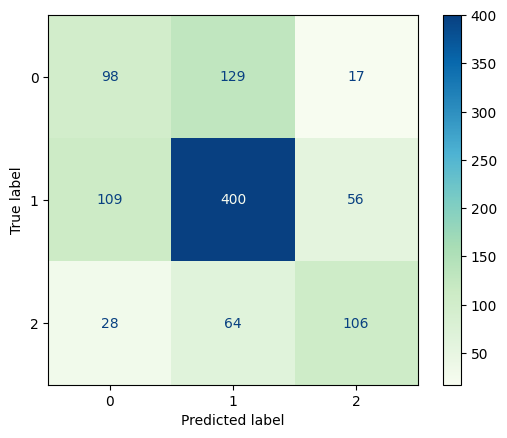

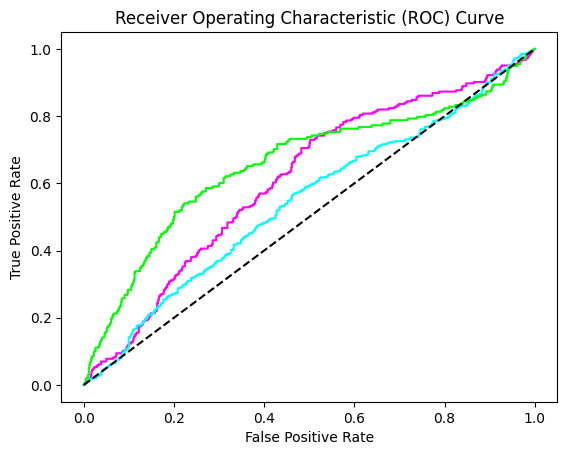

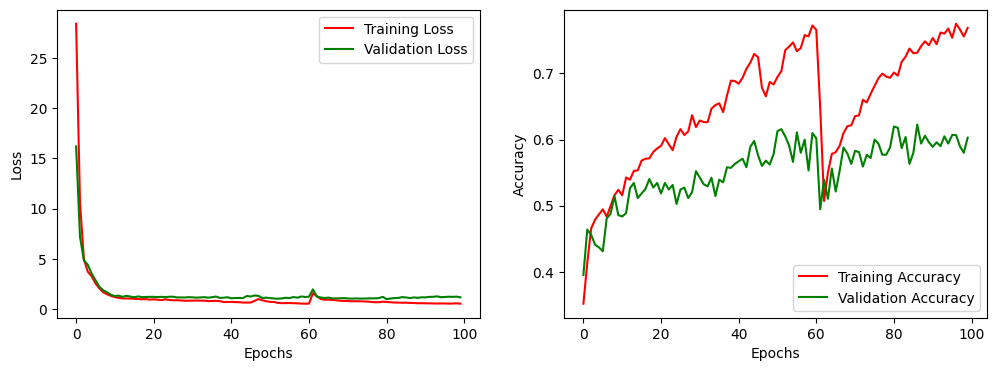

In [16]:
for col in targetColumns:
    print( col)
    X_train, X_test, Y_train, Y_test = split_data_by_target_column(col, train_ds, test_ds)

    X_train = X_train.astype('float32').to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.astype('float32').to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)
    Y_train = Y_train.to_numpy()
    Y_test = Y_test.to_numpy()

    models = [create_rnn(col, X_train), create_gru(col, X_train), create_lstm(col, X_train)]

    for model in models:
        print(model.name)
        print("Train")
        history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64)
        y_pred = model.predict(X_test)
        y_pred1 = pd.DataFrame(y_pred).idxmax(axis=1)
        plot_evaluation_metrics(Y_test, y_pred, y_pred1, model, X_test)
        plot_history(history)


### Conclusions

В ході лабораторної роботи використав та створив from scratch такі моделі як RNN, GRU та LSTM. Дані моделі були розроблені за допомогою бібліотеки tensorflow, адже в порівнянні з torch вони стали легшими у розробці (тестував обидва варіанти, однак у tensorflow присутній зручний токенізатор). В ході написання лабораторної виявив що однією з найважливіших частин є саме підготовка даних для нейронних мереж. Також, на жаль, не зміг запустити на своєму локальному прикладі моделі з пакету трансформерів (BERT, GPT). При спробі їх використання, отримував помилку про неправильну роботу токенізатора, що унеможливлювало подальшу роботу.

Кажучи про продуктивність моделей на даному датасеті, то можемо виокремити модель GRU. На 2\3 прогнозованих даних - вона демонструє найвищий результат (efectiveness та rating) та лише на прогнозуванні  side effects показує трішки нижчі результати за LSTM (54% проти 59% у LSTM), однак на efectiveness демонструє 70% точності. На даному наборі даних LSTM демонструє також непогані результат, з піковою точністю у 60%. Загалом можна сказати, що RNN демонструє найслабшу результативність, однак варто враховувати, що шари RNN є значно простішими, та не містять gate елементів. 

Усі моделі було використано з однаковими гіперпараметрами, а саме активаційна функція прихованих шарів - relu, та вихідного шару - sigmoid. Також, для оптимізатора моделей обрав adam, адже за досвідом попередніх робіт, сформував думку, що він є найстабільнішим з усіх. 

Щодо частини досліджень advanced_rag ноутбуку, виявив, що для даного типу моделей варто використовувати лише машини з  наявністю gpu, адже вони значно пришвидшують виконання (намагався запустити локально FAISS, і після 99-ти хвилинного процесу роботи отримав помилку. До порівняння Google Collab справився за 3 хвилини). Також, виокремив для себе важливість застосування правильного чанкування вхіднив даних для опрацювання, та вибору алгоритму індексації. Також, зрозумів важливість правильної побудови промптів, адже це значно покращує результати відповіді моделей.